# First Attempt

### Import modules

In [1]:
%matplotlib inline
from __future__ import division
import sys
import os
os.environ['MKL_THREADING_LAYER']='GNU'
sys.path.append('../')
from Modules.Basics import *
from Modules.Class_Basics import *

/home/giles/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/giles/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
Using TensorFlow backend.


## Options

In [8]:
classTrainFeatures = basic_features
classModel = 'modelSelu'
varSet = "basic_features"

nSplits = 10
ensembleSize = 10
ensembleMode = 'loss'

maxEpochs = 10000
compileArgs = {'loss':'binary_crossentropy', 'optimizer':'adam'}
trainParams = {'epochs' : 1, 'batch_size' : 256, 'verbose' : 0}
modelParams = {'version':classModel, 'nIn':len(classTrainFeatures), 'compileArgs':compileArgs}

print "\nTraining on", len(classTrainFeatures), "features:", [var for var in classTrainFeatures]


Training on 30 features: ['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'PRI_tau_pt', 'DER_deltar_tau_lep', 'PRI_jet_leading_eta', 'PRI_lep_eta', 'PRI_tau_eta', 'DER_lep_eta_centrality', 'DER_mass_jet_jet', 'DER_deltaeta_jet_jet', 'DER_pt_tot', 'DER_met_phi_centrality', 'PRI_jet_num', 'PRI_met', 'DER_pt_h', 'DER_pt_ratio_lep_tau', 'DER_sum_pt', 'PRI_jet_leading_pt', 'PRI_jet_subleading_eta', 'PRI_jet_all_pt', 'PRI_met_sumet', 'DER_prodeta_jet_jet', 'PRI_lep_pt', 'PRI_jet_subleading_pt', 'PRI_met_phi', 'PRI_jet_leading_phi', 'PRI_lep_phi', 'PRI_jet_subleading_phi', 'PRI_tau_phi']


## Import data

In [9]:
trainData = h5py.File(dirLoc + 'train.hdf5', "r+")
valData = h5py.File(dirLoc + 'val.hdf5', "r+")

## Determine LR

2 classes found, running in binary mode


______________________________________
Training finished
Cross-validation took 1.215s 


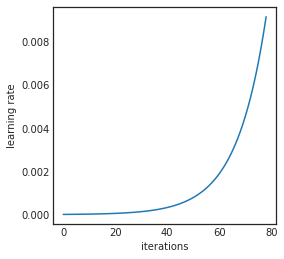

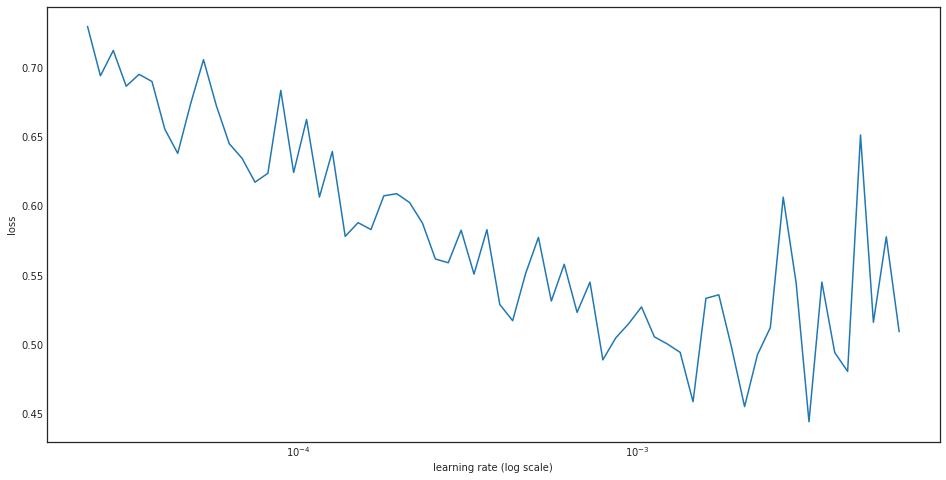

______________________________________



In [10]:
lrFinder = batchLRFindClassifier(trainData, nSplits, getClassifier, modelParams, trainParams, lrBounds=[1e-5,1e-2], trainOnWeights=False, verbose=0)

In [11]:
compileArgs['lr'] = 1e-3

## Train classifier

In [ ]:
results, histories = batchTrainClassifier(trainData, nSplits, getClassifier, modelParams, trainParams, useCosAnneal=True, trainOnWeights=False, maxEpochs=maxEpochs, verbose=1)

Running fold 1 / 10
Using cosine annealing
2 classes found, running in binary mode

1 New best found: 0.462882287512
2 New best found: 0.427998435659
3 New best found: 0.408704337275
4 New best found: 0.399516054874
5 New best found: 0.396258104498
6 New best found: 0.390258984006
7 New best found: 0.388467352092
8 New best found: 0.385980126451
9 New best found: 0.385793199427
10 New best found: 0.383219760826
11 New best found: 0.381654112835
12 New best found: 0.38049812676
13 New best found: 0.378877272373
14 New best found: 0.378293529973
15 New best found: 0.376701902503
17 New best found: 0.375821836988
19 New best found: 0.374984590348
20 New best found: 0.373266656315
21 New best found: 0.372464109598
23 New best found: 0.37240252735
25 New best found: 0.371585704743
27 New best found: 0.371041130219
28 New best found: 0.370799671808
29 New best found: 0.369800833067
31 New best found: 0.369429767213
33 New best found: 0.369136492115
35 New best found: 0.368126415575
40 New be

## Construct ensemble

In [ ]:
with open('train_weights/resultsFile.pkl', 'r') as fin:   
    results = pickle.load(fin)

In [ ]:
ensemble, weights = assembleEnsemble(results, ensembleSize, ensembleMode, compileArgs)

## Response on development data

In [ ]:
batchEnsemblePredict(ensemble, weights, trainData, ensembleSize=10, verbose=1)

In [ ]:
print 'Training ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', trainData), getFeature('pred', trainData)),
                                                            roc_auc_score(getFeature('targets', trainData), getFeature('pred', trainData), sample_weight=getFeature('weights', trainData)))

## Response on val data

In [ ]:
batchEnsemblePredict(ensemble, weights, testData, ensembleSize=10, verbose=1)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', testData), getFeature('pred', testData)),
                                                           roc_auc_score(getFeature('targets', testData), getFeature('pred', testData), sample_weight=getFeature('weights', testData)))

## Evaluation

### Import in dataframe

In [ ]:
def convertToDF(datafile, columns={'gen_target', 'gen_weight', 'gen_sample', 'pred_class'}, nLoad=-1):
    data = pandas.DataFrame()
    data['gen_target'] = getFeature('targets', datafile, nLoad)
    data['gen_weight'] = getFeature('weights', datafile, nLoad)
    data['gen_sample'] = getFeature('gen_sample', datafile, nLoad)
    data['pred_class'] = getFeature('pred', datafile, nLoad)
    print len(data), "candidates loaded"
    return data

In [ ]:
devData = convertToDF(trainData)
valData = convertToDF(testData)

In [ ]:
sigVal = (valData.gen_target == 1)
bkgVal = (valData.gen_target == 0)

### ROC curve

In [ ]:
rocPlot(inData=[devData, valData],
        params=[{'linestyle':'dashed', 'color':'b'}, {'color':'b'}],
        labels=['Train', 'Test'], weightName='gen_weight')

### MVA distributions

In [ ]:
getClassPredPlot([valData[bkgVal], valData[sigVal]], weightName='gen_weight')

In [ ]:
getSamplePredPlot(valData)

## Save classified data

In [ ]:
name = dirLoc + signal + "_" + channel + "_" + varSet + '_' + classModel + '_classifiedData.csv'
print "Saving data to", name
valData.to_csv(name, columns=['gen_target', 'gen_weight', 'gen_sample', 'pred_class'])

## Save/load

In [ ]:
name = "weights/DNN_" + signal + "_" + channel + "_" + varSet + '_' + classModel
print name

### Save

In [ ]:
saveEnsemble(name, ensemble, weights, compileArgs, overwrite=1)

### Load

In [ ]:
ensemble, weights, compileArgs, inputPipe, outputPipe = loadEnsemble(name)